Load dataset and visualize some samples

['gallina', 'ragno']


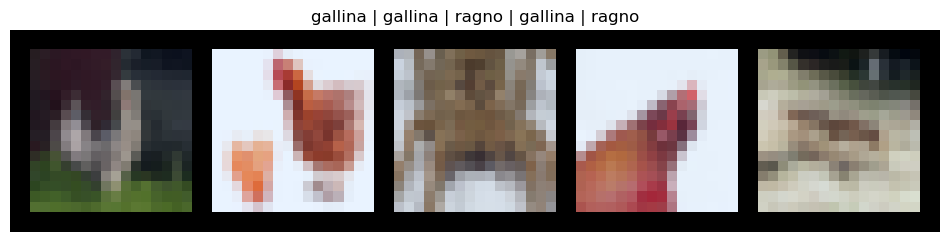

Number of images in dataset = 2375


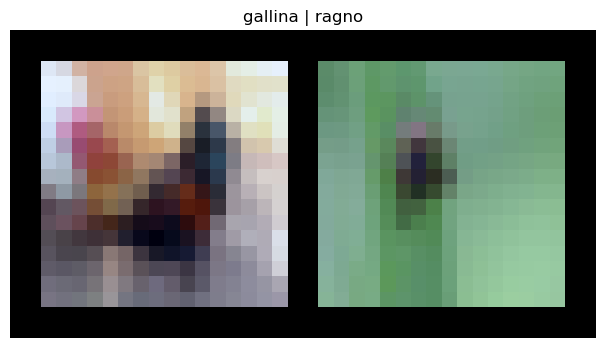

In [1]:
from torchvision import transforms, utils
from Dataset import CustomImageDataset

NUM_OF_CLASSES = 2
IMAGE_SIZE = (64, 64)
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE[0], IMAGE_SIZE[1])), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = CustomImageDataset('data/raw-img', transform=transform, amount_of_classes=NUM_OF_CLASSES, data_percentage=0.3)

dataset.visualize(5)

print("Number of images in dataset =", len(dataset))

dataset.visualize_all_classes()

#print(dataset.nr_classes)

In [2]:
#define model

import torch.nn as nn
import torch.nn.functional as F
import torch

class ClassificationModel(nn.Module):
    def __init__(self, num_classes=10, input_size=(500, 500)):
        super(ClassificationModel, self).__init__()
        
        # First convolutional layer: 3 input channels (RGB), 32 output channels, kernel size 5, padding 2 to preserve size
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        
        # Second convolutional layer: outputs a 32-channel feature map
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        
        # Third convolutional layer: further reduces spatial dimensions
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

        # Calculate the size of the fully connected layer dynamically
        self.fc_input_size = self._get_fc_input_size(input_size)
        self.fc1 = nn.Linear(self.fc_input_size, 512)  # Adjusted for the final size after pooling
        
        # Prediction layer
        self.prediction = nn.Linear(512, num_classes)
        
    def _get_fc_input_size(self, input_size):
        x = torch.zeros(1, 3, *input_size)  # Create a dummy input tensor
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2)
        return x.numel()  # Total number of elements after conv layers
    
    def forward(self, x):
        # First conv -> ReLU -> Max Pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)

        # Second conv -> ReLU -> Max Pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)

        # Third conv -> ReLU -> Max Pooling
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten the tensor for fully connected layer
        x = x.view(x.size(0), -1)  # Output: (batch_size, 128 * 16 * 16) for 500x500 input

        # Fully connected layer -> ReLU
        x = F.relu(self.fc1(x))

        # Output layer (no activation, to be combined with a loss function later)
        x = self.prediction(x)
        # Optionally remove Softmax from here
        return x


In [3]:
from torchsummary import summary
model = ClassificationModel(num_classes=NUM_OF_CLASSES, input_size=IMAGE_SIZE)

summary(model, (3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           2,432
            Conv2d-2             [-1, 64, 8, 8]          51,264
            Conv2d-3            [-1, 128, 4, 4]         204,928
            Linear-4                  [-1, 512]         262,656
            Linear-5                    [-1, 2]           1,026
Total params: 522,306
Trainable params: 522,306
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 1.99
Estimated Total Size (MB): 2.11
----------------------------------------------------------------


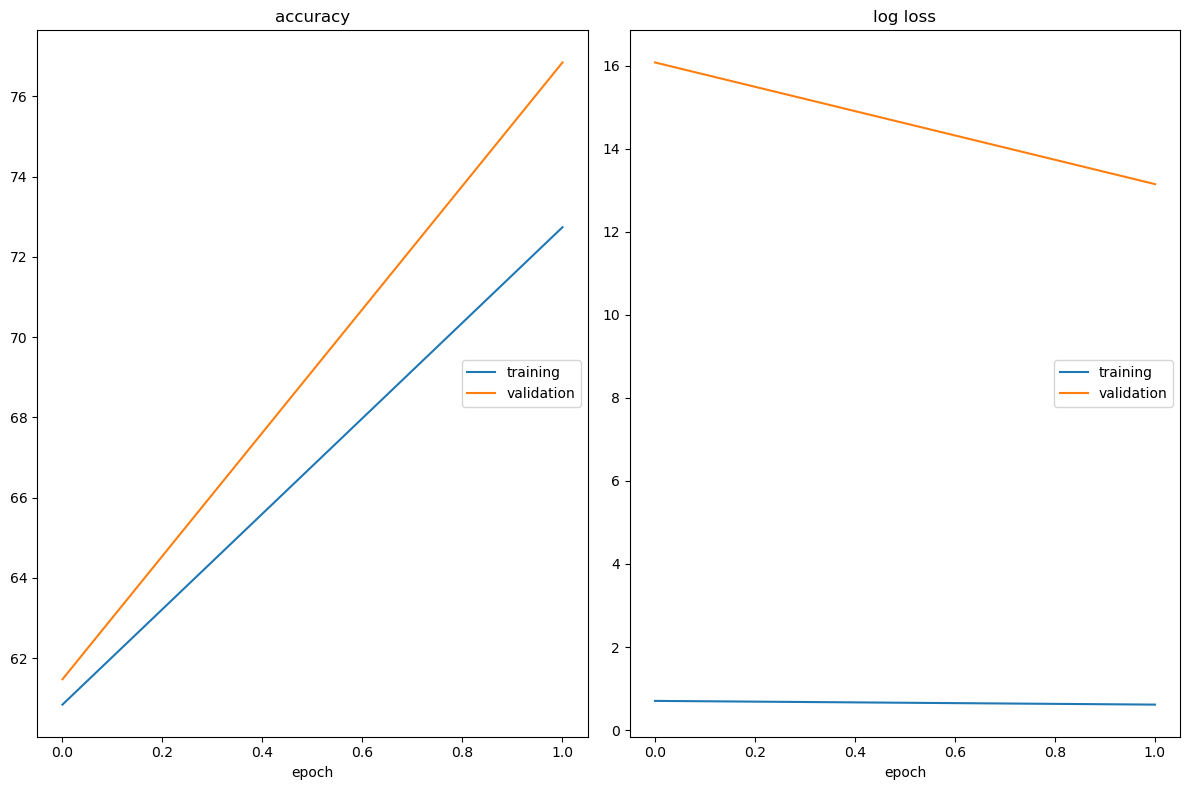

accuracy
	training         	 (min:   60.842, max:   72.737, cur:   72.737)
	validation       	 (min:   61.474, max:   76.842, cur:   76.842)
log loss
	training         	 (min:    0.614, max:    0.703, cur:    0.614)
	validation       	 (min:   13.147, max:   16.077, cur:   13.147)

Epoch: 2


In [ ]:
from models.ClassificationModel import ClassificationModel
from train import train
from test_model import test
import torch.optim
from torch.utils.data import DataLoader, random_split
import torch.nn as nn


device = 'mps'

START_EPOCH = 0
EPOCHS = 100
MODEL_NAME = "TJENA"
ID = 2213
LR = 0.001
BATCH_SIZE = 1

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size   # 20% for validation

print(train_size, val_size)

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)





optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCELoss()


model.to(device)



model, loss, acc = train(model, train_loader, val_loader, optimizer, criterion, device, start_epoch=START_EPOCH , num_epochs=EPOCHS, model_name=MODEL_NAME, unique_id=ID)

acc = test(model=model, testloader=val_loader, device=device, model_name=MODEL_NAME, unique_id=ID )
